[2021-04-29 13:20 Now out of date compared to website]

This post should answer the question: "Can neural networks learn the Fourier transform?"

We can consider the the discrete Fourier transform (DFT) to be an artificial neural network:
it is a single layer network, with no bias, no activation function, and particular values for the weights. 
The number of output nodes is equal to the number of frequencies we evaluate.

Here is the DFT:

$$ y_k = \displaystyle \sum_{n=0}^{N-1} x_n \cdot \exp(-i\frac{2 \pi k}{N}n) \tag{1} $$

Where $k$ is the number of cycles per $N$ samples, $x_n$ is the signal's value at sample $n$, and $N$ is the length of the signal.

(Fourier overview: any signal can be written as the sum of sinusoids. $y_k$ is a complex value that gives us information about the sinusoid of frequency $k$ in signal $\boldsymbol{x}$. From $y_k$ we can compute the amplitude and phase (i.e. location) of the sinusoid.)

We can rewrite (1) using matrix multiplication:

$$ y_k = [x_0, x_1,... x_{N-1}]
\begin{bmatrix}
    \exp(0)\\
    \exp(-i\frac{2 \pi k}{N})\\
    \exp(-i\frac{2 \pi k}{N}2)\\
    \exp(-i\frac{2 \pi k}{N}3)\\
    \exp(-i\frac{2 \pi k}{N}4)\\
    \vdots \\
    \exp(-i\frac{2 \pi k}{N}(N-1))
\end{bmatrix}
$$ 

This gives us the Fourier value for a particular $k$. 
However, we most commonly want to compute the full frequency spectrum, i.e. values of $k$ from $[0, 1, ... N-1]$.
We can use a matrix for this ($k$ is incremented column-wise, and $n$ row-wise):

$$ [y_0... y_{N-1}] = [x_0... x_{N-1}]
\begin{bmatrix}
    \exp(0)     & \exp(0)                     & \exp(0)                      & \dots  & \exp(0) \\
    \exp(0)     & \exp(-i\frac{2\pi}{N})      & \exp(-i\frac{2\pi2}{N})      & \dots  & \exp(-i\frac{2\pi(N-1)}{N}) \\
    \exp(0)     & \exp(-i\frac{2\pi}{N}2)     & \exp(-i\frac{2\pi2}{N}2)     & \dots  & \exp(-i\frac{2\pi(N-1)}{N}2)\\ 
    \exp(0)     & \exp(-i\frac{2\pi}{N}3)     & \exp(-i\frac{2\pi2}{N}3)     & \dots  & \exp(-i\frac{2\pi(N-1)}{N}3)\\ 
    \vdots      & \vdots                      & \vdots                       &        & \vdots \\
    \exp(0)     & \exp(-i\frac{2\pi}{N}(N-1)) & \exp(-i\frac{2\pi2}{N}(N-1)) & \dots  & \exp(-i\frac{2\pi(N-1)}{N}(N-1))
\end{bmatrix}
$$ 

More concisely:

$$ \boldsymbol{y} = \boldsymbol{x} W_{Complex Fourier} \tag{2} $$

This should look familiar, because it is a neural network layer with no activation function and no bias.
The matrix of exponentials contains our weights, which we'll call "complex Fourier weights".
Usually we don't know the weights of our neural networks in advance, but in this case we do.

### Non-complex

However, we typically don't use complex numbers for neural networks. To fit in with this, we'll double the size of our matrix. The left half will contain the real values, and the right half the imaginary values.

Recall that:

$$ e^{-i\theta} = cos(\theta) - i sin(\theta) $$

Substituting in $ \theta = \frac{2 \pi k}{N}n  $ from our DFT expression [1], we get:

$$ \exp(-i \frac{2 \pi k}{N}n) = cos(\frac{2 \pi k}{N}n) - i sin(\frac{2 \pi k}{N}n) $$

Then we use the real part (the $cos$ term) for the left half of our matrix, 
and the imaginary part (the $sin$ term) for the right half.

$$ \boldsymbol{\hat{y}} = [x_0 ... x_{N-1}]
\begin{bmatrix}
    \cos(0)     & \cos(0)                   & \dots  & \cos(0) & -\sin(0) & -\sin(0) & \dots & -\sin(0)\\
    \cos(0)     & \cos(\frac{2\pi}{N})      & \dots  & \cos(\frac{2\pi(N-1)}{N}) & -\sin(0)     & -\sin(\frac{2\pi}{N})      & \dots & -\sin(\frac{2\pi(N-1)}{N})\\
    \cos(0)     & \cos(\frac{2\pi}{N}2)     & \dots  & \cos(\frac{2\pi(N-1)}{N}2) & -\sin(0)     & -\sin(\frac{2\pi}{N}2)     & \dots & -\sin(\frac{2\pi(N-1)}{N}2)\\
    \cos(0)     & \cos(\frac{2\pi}{N}3)     & \dots  & \cos(\frac{2\pi(N-1)}{N}3) & -\sin(0)     & -\sin(\frac{2\pi}{N}3)     & \dots & -\sin(\frac{2\pi(N-1)}{N}3)\\ 
    \vdots      & \vdots                    &        & \vdots & \vdots  & \vdots                      &       & \vdots\\
    \cos(0)     & \cos(\frac{2\pi}{N}(N-1)) & \dots  & \cos(\frac{2\pi(N-1)}{N}(N-1)) & -\sin(0)     & -\sin(\frac{2\pi}{N}(N-1)) & \dots & -\sin(\frac{2\pi(N-1)}{N}(N-1))
\end{bmatrix}
$$ 

More concisely:

$$ \boldsymbol{\hat{y}} = \boldsymbol{x} W_{Fourier} \tag{3}$$

We'll call $W_{Fourier}$, "Fourier weights".
Note that $\boldsymbol{\hat{y}}$ and $\boldsymbol{y}$ effectively contain the same information, but $\boldsymbol{\hat{y}}$ doesn't use complex numbers, so it is twice as long. In other words, we could compute amplitudes and phases using either $W_{Fourier}$ or $W_{Complex Fourier}$, but we probably want to use $W_{Fourier}$ in order to avoid complex numbers. 

We are now equipped to add Fourier layers to our networks, if we so choose...

## Computing the Fourier transform using Fourier weights

Let's implement the method shown above (non-complex, expression 3), and check it is correct using the fast Fourier transform.

In [1]:
import numpy as np


def create_fourier_weights(signal_length):
    "Create weights, as described above."
    k_vals, n_vals = np.mgrid[0:signal_length, 0:signal_length]
    theta_vals = 2 * np.pi * k_vals * n_vals / signal_length
    return np.hstack([np.cos(theta_vals), -np.sin(theta_vals)])


# Generate data:
signal_length = 64
x = np.random.random(size=[1, signal_length]) - 0.5

# Compute Fourier transform using method described above:
W_fourier = create_fourier_weights(signal_length)
y = np.matmul(x, W_fourier)

# Compute Fourier transform using the fast Fourier transform:
fft = np.fft.fft(x)
y_fft = np.hstack([fft.real, fft.imag])

# Compare the results:
print("rmse: ", np.sqrt(np.mean((y - y_fft) ** 2)))

rmse:  1.5429611622665193e-14


The tiny error confirms that we are computing what we expect.

Another way of checking is to reconstruct the signal:

rmse: 2.3243522568191728e-15


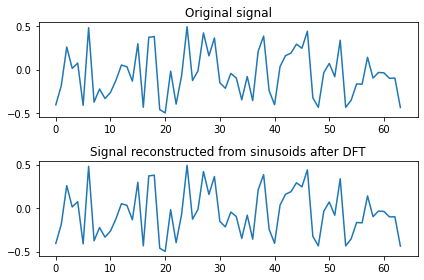

In [2]:
import matplotlib.pyplot as plt

y_real = y[:, :signal_length]
y_imag = y[:, signal_length:]
tvals = np.arange(signal_length).reshape([-1, 1])
freqs = np.arange(signal_length).reshape([1, -1])
arg_vals = 2 * np.pi * tvals * freqs / signal_length
sinusoids = (y_real * np.cos(arg_vals) - y_imag * np.sin(arg_vals)) / signal_length
reconstructed_signal = np.sum(sinusoids, axis=1)

print("rmse:", np.sqrt(np.mean((x - reconstructed_signal) ** 2)))
plt.subplot(2, 1, 1)
plt.plot(x[0, :])
plt.title("Original signal")
plt.subplot(2, 1, 2)
plt.plot(reconstructed_signal)
plt.title("Signal reconstructed from sinusoids after DFT")
plt.tight_layout()
plt.show()

## Learning the Fourier transform via gradient-descent

We don't need to pre-compute the weights, like we did above, we can instead *learn them*.

First, similarly to [endolith (GitHub Gist)](https://gist.github.com/endolith/98863221204541bf017b6cae71cb0a89), we will use the FFT to train a network to carry out the DFT:

In [3]:
import tensorflow as tf

signal_length = 32

# Initialise weight vector to train:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

# Expected weights, for comparison:
W_expected = create_fourier_weights(signal_length)

losses = []
rmses = []

for i in range(1000):
    # Generate a random signal each iteration:
    x = np.random.random([1, signal_length]) - 0.5

    # Compute the expected result using the FFT:
    fft = np.fft.fft(x)
    y_true = np.hstack([fft.real, fft.imag])

    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        loss = tf.reduce_sum(tf.square(y_pred - y_true))

    # Train weights, via gradient descent:
    W_gradient = tape.gradient(loss, W_learned)
    W_learned = tf.Variable(W_learned - 0.1 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected) ** 2)))

Final loss value 1.6738563548424711e-09
Final weights' rmse value 3.1525832404710523e-06


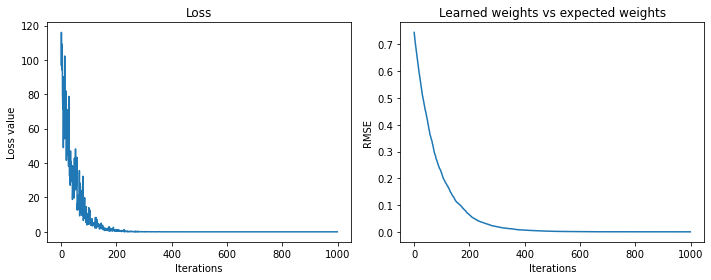

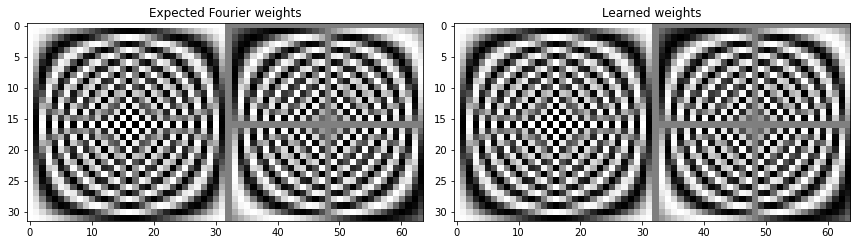

In [4]:
print("Final loss value", np.mean(losses[-10:]))
print("Final weights' rmse value", np.mean(rmses[-10:]))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss")
plt.ylabel("Loss value")
plt.xlabel("Iterations")
plt.subplot(1, 2, 2)
plt.plot(rmses)
plt.title("Learned weights vs expected weights")
plt.ylabel("RMSE")
plt.xlabel("Iterations")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.title("Expected Fourier weights")
plt.imshow(W_expected, cmap="gray", vmin=-1, vmax=1)
plt.subplot(1, 2, 2)
plt.title("Learned weights")
plt.imshow(W_learned, cmap="gray", vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

This confirms that neural networks are capable of learning the discrete Fourier transform. 
However, this example is contrived -
if we are going to train a single layer to learn the Fourier transform, we might as well use `create_fourier_weights` directly (or tf.signal.fft, etc.).

## Learning the Fourier transform via a Fourier autoencoder

We used the FFT above, to teach the network to perform the Fourier transform. Let's not use it anymore, and instead learn the DFT autoencoder-style.

In [5]:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

tvals = np.arange(signal_length).reshape([-1, 1])
freqs = np.arange(signal_length).reshape([1, -1])
arg_vals = 2 * np.pi * tvals * freqs / signal_length
cos_vals = tf.cos(arg_vals) / signal_length
sin_vals = tf.sin(arg_vals) / signal_length

losses = []
rmses = []

for i in range(10000):
    x = np.random.random([1, signal_length]) - 0.5

    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        y_real = y_pred[:, 0:signal_length]
        y_imag = y_pred[:, signal_length:]
        sinusoids = y_real * cos_vals - y_imag * sin_vals
        reconstructed_signal = tf.reduce_sum(sinusoids, axis=1)
        loss = tf.reduce_sum(tf.square(x - reconstructed_signal))

    W_gradient = tape.gradient(loss, W_learned)
    W_learned = tf.Variable(W_learned - 0.5 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected) ** 2)))

Final loss value 4.161919455121241e-22
Final weights' rmse value 0.20243339269590094


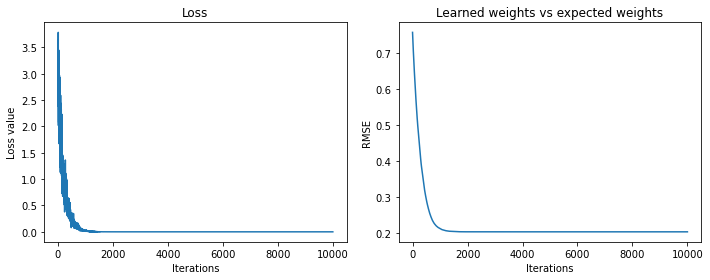

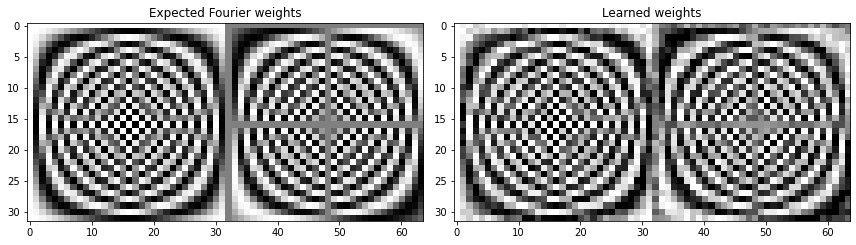

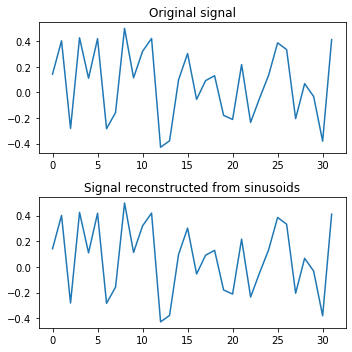

In [6]:
print("Final loss value", np.mean(losses[-10:]))
print("Final weights' rmse value", np.mean(rmses[-10:]))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss")
plt.ylabel("Loss value")
plt.xlabel("Iterations")
plt.subplot(1, 2, 2)
plt.plot(rmses)
plt.title("Learned weights vs expected weights")
plt.ylabel("RMSE")
plt.xlabel("Iterations")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.title("Expected Fourier weights")
plt.imshow(W_expected, cmap="gray", vmin=-1, vmax=1)
plt.subplot(1, 2, 2)
plt.title("Learned weights")
plt.imshow(W_learned, cmap="gray", vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.title("Original signal")
plt.plot(x[0, :])
plt.subplot(2, 1, 2)
plt.title("Signal reconstructed from sinusoids")
plt.plot(reconstructed_signal)
plt.tight_layout()
plt.show()

And we pretty much learn the Fourier transform.
The learned weights don't get as close to the Fourier weights as they did in the example above, 
but the reconstructed signals are perfect.

## Fourier autoencoder, amplitude + phase reconstruction

Let's do the same as above, but explicitly using amplitude and phase.

In [7]:
W_learned = tf.Variable(np.random.random([signal_length, 2 * signal_length]) - 0.5)

losses = []
rmses = []

for i in range(10000):
    x = np.random.random([1, signal_length]) - 0.5

    with tf.GradientTape() as tape:
        y_pred = tf.matmul(x, W_learned)
        y_real = y_pred[:, 0:signal_length]
        y_imag = y_pred[:, signal_length:]
        amplitudes = tf.sqrt(y_real**2 + y_imag**2) / signal_length
        phases = tf.atan2(y_imag, y_real)
        sinusoids = amplitudes * tf.cos(arg_vals + phases)
        reconstructed_signal = tf.reduce_sum(sinusoids, axis=1)
        loss = tf.reduce_sum(tf.square(x - reconstructed_signal))

    W_gradient = tape.gradient(loss, W_learned)
    W_learned = tf.Variable(W_learned - 0.5 * W_gradient)

    losses.append(loss)
    rmses.append(np.sqrt(np.mean((W_learned - W_expected) ** 2)))

Final loss value 2.2379359316633115e-21
Final weights' rmse value 0.2080118219691059


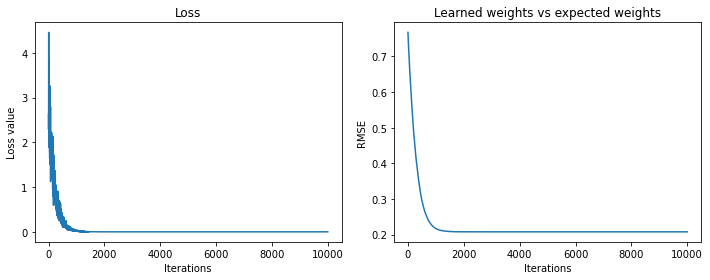

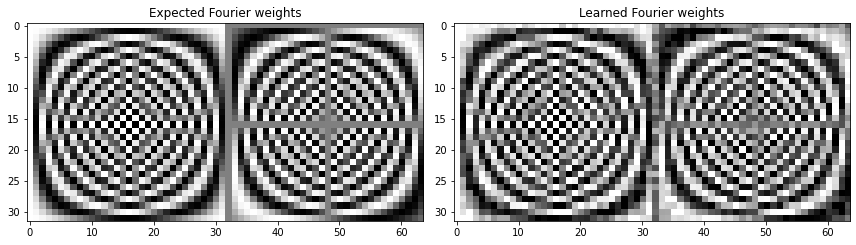

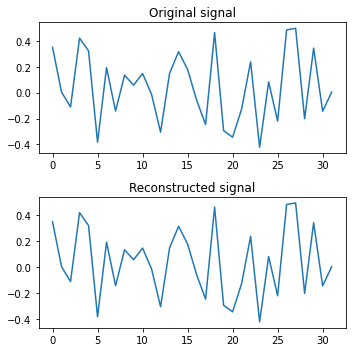

In [8]:
print("Final loss value", np.mean(losses[-10:]))
print("Final weights' rmse value", np.mean(rmses[-10:]))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss")
plt.ylabel("Loss value")
plt.xlabel("Iterations")
plt.subplot(1, 2, 2)
plt.plot(rmses)
plt.title("Learned weights vs expected weights")
plt.ylabel("RMSE")
plt.xlabel("Iterations")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.title("Expected Fourier weights")
plt.imshow(W_expected, cmap="gray", vmin=-1, vmax=1)
plt.subplot(1, 2, 2)
plt.title("Learned Fourier weights")
plt.imshow(W_learned, cmap="gray", vmin=-1, vmax=1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.title("Original signal")
plt.plot(x[0, :])
plt.subplot(2, 1, 2)
plt.title("Reconstructed signal")
plt.plot(reconstructed_signal)
plt.tight_layout()
plt.show()

Once again we get perfect reconstructions, so we know that the amplitudes and phases must be accurate.
However, as before, the learned weights aren't exactly the same as the Fourier weights (but pretty close).
So we can surmise that there is some flexibility in the weights that result in the Fourier transform, and that gradient descent takes us to a local optimum.


So, to conclude: yes, neural networks can learn the Fourier transform.

And this post leaves unaddressed the questions:

- What is the explanation for the flexibility in the weights? How much flexibility is there?
- Do we ever benefit from explicitly putting Fourier layers into our models? Or are we better off using good architectures and assuming the model will learn what it needs to?

### References

https://en.wikipedia.org/wiki/Discrete_Fourier_transform

 Training neural network to implement discrete Fourier transform (DFT/FFT) - 2018 - https://gist.github.com/endolith/98863221204541bf017b6cae71cb0a89

Discrete Fourier Transform Computation Using Neural Networks - 2008 - 
https://publik.tuwien.ac.at/files/PubDat_171587.pdf